In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19



First we load the desired data from a source we also need to tell the class to download the data

In [2]:
rki = cov19.data_retrieval.RKI(True)
#rki.download_all_available_data() #True argument above does this


INFO     [covid19_inference.data_retrieval] Loading local file.
INFO     [covid19_inference.data_retrieval] Downloading new dataset from repository since it is newer.
INFO     [covid19_inference.data_retrieval] Overwriting /data/rki_fallback_gzip.dat fallback with newest downloaded ones


Wait for the download to finish. It will print a message!

We can now access this downloaded data by the attribute but normaly one would use the build in filter methods.
```
rki.data
```

In [3]:
df_bundeslaender = rki.filter_all_bundesland('2020-03-10', '2020-04-19')
new_cases_obs = np.diff(np.array(df_bundeslaender),axis=0)[:,:]


date_begin_data = datetime.datetime(2020,3,10)
date_end_data   = datetime.datetime(2020,4,19)
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

prior_date_mild_dist_begin =  datetime.datetime(2020,3,11)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,18)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,25)


change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5,
                     pr_sigma_transient_len=0.5),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5,
                     pr_sigma_transient_len=0.5),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5,
                     pr_sigma_transient_len=0.5)];

In [4]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 
# normally one would put as N_population an array with the number of inhabitants of 
# of each state

with cov19.Cov19Model(**params_model) as model:
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4, pr_sigma_lambda_0 = 0.5,
                                                change_points_list = change_points)
    
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8, pr_I_begin=20)
    
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [5]:
trace = pm.sample(model=model, tune=1000, draws=1000, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 3,349.2:  25%|██▍       | 49899/200000 [02:21<07:04, 353.55it/s]
Convergence achieved at 49900
INFO     [pymc3.variational.inference] Convergence achieved at 49900
Interrupted at 49,899 [24%]: Average Loss = 3,951.8
INFO     [pymc3.variational.inference] Interrupted at 49,899 [24%]: Average Loss = 3,951.8
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_L2_raw, weekend_factor_L1, sigma_weekend_factor_L2, delay_log_L2_raw, delay_log_L1, sigma_delay_L2, I_begin, mu, transient_len_3_log_L2_raw, transient_len_3_log_L1, sigma_transient_len_3_L2, transient_len_2_log_L2_raw, transient_len_2_log_L1, sigma_transient_len_2_L2, transient_len_1_log_L2_raw, transient_len_1_log_L1, sigma_transient_

### Plot
We first define the x range on which we want to plot and create a datetime array for that range. Should be within the simulation period.

In [76]:
bd = datetime.datetime(2020,3,10)
ed = datetime.datetime(2020,4,19) + datetime.timedelta(days=num_days_forecast-1)
x = pd.date_range(bd,ed)
x

DatetimeIndex(['2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
               '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
               '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
               '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
               '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
               '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
               '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
               '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18',
               '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22',
               '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
               '2020-04-27', '2020-04-28'],
              dtype='datetime64[ns]', freq='D')

Next we have to get our trace corresponding to that date range. We do that by calling the helper function `cov19.plot._get_array_from_trace_via_date()`.

In [77]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
y_all_regions = cov19.plot._get_array_from_trace_via_date(model,trace["new_cases"],x)


data with ndim 3


IndexError: index 50 is out of bounds for axis 1 with size 50

Depending on which trace variable we want to plot we have to look at the shape and maybe reshape it to match date length and maybe also sort the regions. Also the plot function wants a one dimensional array.

After that we plot the timeseries. And set the format of the date axis.

In [82]:
trace.varnames

AttributeError: 'list' object has no attribute 'shape'

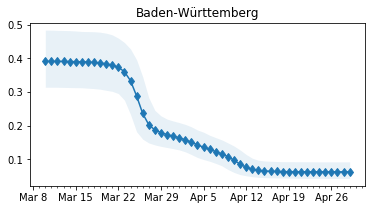

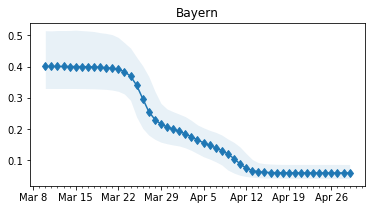

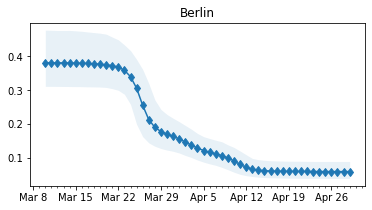

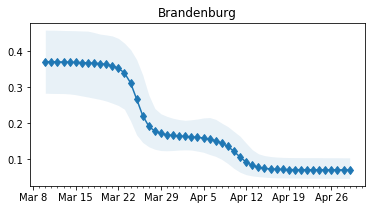

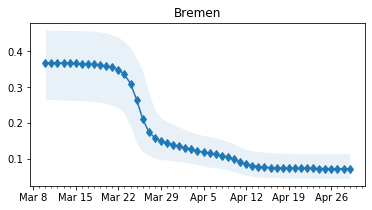

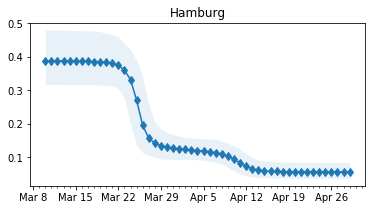

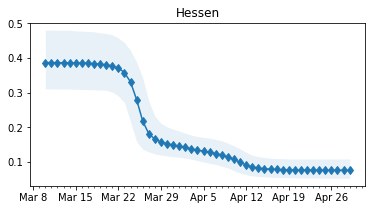

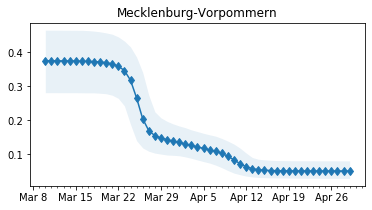

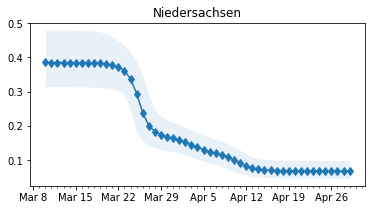

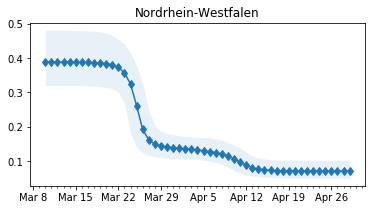

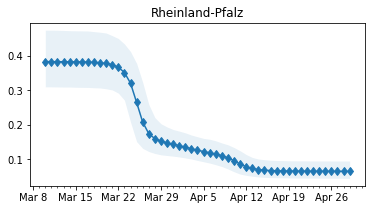

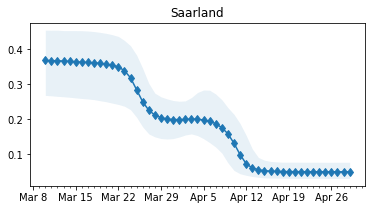

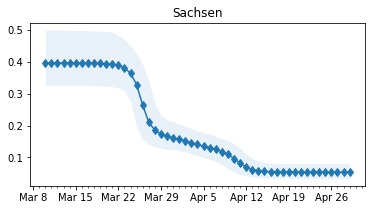

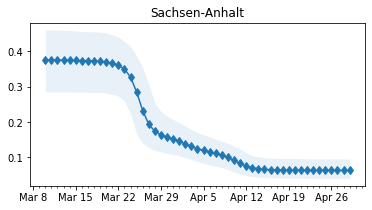

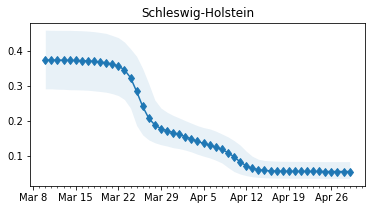

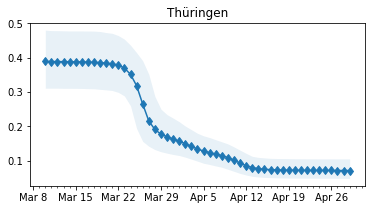

In [56]:
for i in range(16):
    y = y_all_regions[:,:,i]
    ax = cov19.plot._timeseries(x,y)
    ax.set_title(df_bundeslaender.columns[i])
    cov19.plot._format_date_xticks(ax)
plt.show()

In [ ]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)

In [ ]:
for var_name in ['lambda_0_L2', 'lambda_1_L2', 'lambda_2_L2', 'lambda_3_L2',
                 'transient_day_1_L2', 'transient_day_2_L2', 'transient_day_3_L2', 'delay_L2']:
    f, ax = plt.subplots()
    ax.violinplot(trace[var_name], showextrema=False, vert=False)
    ax.set_yticks(np.arange(1,17))
    ax.set_yticklabels(df_bundeslaender.columns)
    ax.set_xlabel(var_name)